In [1]:
import sys
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
d = os.path.dirname(os.getcwd())
sys.path.insert(0, d)

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

from torchvision.datasets import CIFAR10
from torchvision import transforms


from utils.train_utils import ModelTrainer, plot_history
from models.wide_resnet import WideResNet
from utils.attacks import pgd

In [3]:
tr_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])
vl_transform = transforms.Compose([
    transforms.ToTensor()
])

ds_train = CIFAR10('../data', train=True, download=True, transform=tr_transform)
ds_test = CIFAR10('../data', train=False, download=True, transform=vl_transform)

Files already downloaded and verified
Files already downloaded and verified


# Wide-ResNet

## Natural training

cuda
Epoch: 1 Validation Loss: 1.2102 accuracy: 0.5561, time: 0:06:04                
Epoch: 2 Validation Loss: 0.9443 accuracy: 0.6697, time: 0:06:02                
Epoch: 3 Validation Loss: 0.7969 accuracy: 0.7185, time: 0:06:01                
Epoch: 4 Validation Loss: 0.6874 accuracy: 0.7592, time: 0:06:02                
Epoch: 5 Validation Loss: 0.5985 accuracy: 0.7948, time: 0:06:02                
Epoch: 6 Validation Loss: 0.5588 accuracy: 0.8070, time: 0:06:01                
Epoch: 7 Validation Loss: 0.4991 accuracy: 0.8289, time: 0:05:40                
Epoch: 8 Validation Loss: 0.4495 accuracy: 0.8436, time: 0:06:03                
Epoch: 9 Validation Loss: 0.4458 accuracy: 0.8482, time: 0:06:02                
Epoch: 10 Validation Loss: 0.4129 accuracy: 0.8573, time: 0:06:02               
Epoch: 11 Validation Loss: 0.3903 accuracy: 0.8690, time: 0:06:02               
Epoch: 12 Validation Loss: 0.3598 accuracy: 0.8785, time: 0:06:01               
Epoch: 13 Validation Lo

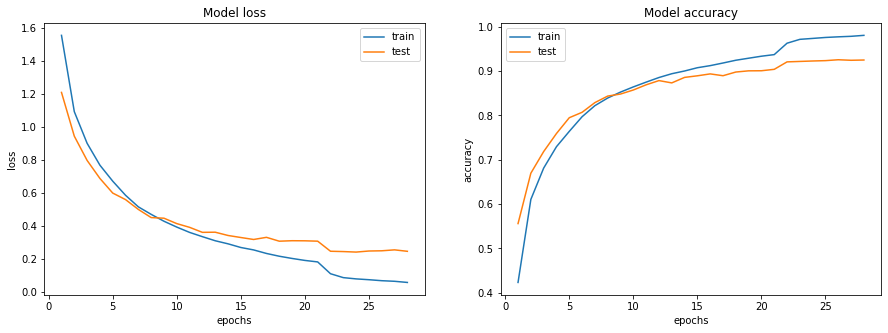

In [4]:
trainer = ModelTrainer(ds_train, ds_test, is_sparse=False, batch_size=100)

model = WideResNet(depth=28, widen_factor=10, dropout_rate=0.3, num_classes=10)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-7, patience=2, verbose=True)

history = trainer.train(model, loss_fn, optimizer, scheduler, epochs=50, patience=4)
plot_history(history)
torch.save(model.state_dict(), "../saved/wide_resnet.pt")

## Adversarial Training

In [4]:
attack_params = {
    "epsilon": 8/255,
    "alpha": 2/255,
    "num_iter": 10
}

In [ ]:
trainer = ModelTrainer(ds_train, ds_test, is_sparse=False, batch_size=100)
model = WideResNet(depth=28, widen_factor=10, dropout_rate=0.3, num_classes=10)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-7, patience=2, verbose=True)

history = trainer.adv_train(model, pgd, attack_params, loss_fn, optimizer, scheduler, epochs=30, patience=5)
plot_history(history)
torch.save(model.state_dict(), "../saved/robust_wide_resnet.pt")

In [ ]:
trainer = ModelTrainer(ds_train, ds_test, is_sparse=False, batch_size=100)
model = WideResNet(depth=28, widen_factor=10, dropout_rate=0.3, num_classes=10)
model.load_state_dict(torch.load("../saved/wide_resnet.pt", map_location=trainer.device))

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', min_lr=1e-7, patience=2, verbose=True)

history = trainer.adv_train(model, pgd, attack_params, loss_fn, optimizer, scheduler, epochs=30, patience=5)
plot_history(history)
torch.save(model.state_dict(), "../saved/robust_wide_resnet.pt")